# Evaluation of ICs for Thrust Control with and without Parallel Computing


Evaluation of data acquired from control cascade in MoCap lab with thrust command

    ref_types = ["spiral", "figure8"]
    ref_type = ref_types[1]
    speed = [0.6, 0.6, 0.3] #FINAL: 0.6
    space_spiral = [1.5, 1.0, 0.7]
    space_figure8 = [1.5, 1.5, 0.7]
    if ref_type == "spiral":
        reference = ReferenceTrajectory(curve=ref_type, space = space_spiral, tscale = speed)
    else:
        reference = ReferenceTrajectory(curve=ref_type, space = space_figure8, tscale = speed)

## Imports and Loading Data


In [222]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import tikzplotlib as tplt
import glob
from uav_params import UAVParams


In [223]:
# load model data
save_plots = True
model_data_folder = "params"
models_file = ["lateral_crazyflie", "lateral_crazyflie", "altitude_crazyflie"]
plot_label_font = 10
plot_legend_font = 10

# Load parameters of dynamics and cost function
models = []
for model_file in models_file:
    with open(model_data_folder+"/"+"ctrl_"+model_file+".pkl", 'rb') as infile:
        models.append(pickle.load(infile))

with open(model_data_folder+"/"+"ctrl_"+"attitude_crazyflie"+".pkl", 'rb') as infile:
    model_att = pickle.load(infile)
pass

# Load data from results folder
folder_results = 'results/cf_flight/'
folder_data = 'data/'
trajectories = ['spiral', 'figure8']
controllers = ['ic','eic','ic_par','eic_par']
data = {}
dt_data = {}
time = {}
time_diff = {}
t_mission = 30.0
cf_data = {}
date_name = '2023-02-28-'
which_data = -1
for trajectory in trajectories:
    for controller in controllers:
        if controller == 'ic' or controller == 'eic':
            date_name = '2023-02-28-'
            path = folder_results+folder_data+'log_controller_'+trajectory+'_thrust_'+controller+'_'+date_name
            path_dt = folder_results+folder_data+'time_'+trajectory+'_thrust_'+controller+'_'+date_name
            path_cf = folder_results + folder_data + 'cflib_log_'+trajectory+'_' + controller+'_thrust_'+date_name
            path_time_traj = folder_results + folder_data + "time_traj_"+trajectory+'_thrust_'+controller+'_'+date_name
        else:
            controller_name = controller.split("_")[0]
            date_name = '2023-02-27-'
            path = folder_results+folder_data+'log_controller_'+trajectory+'_thrust_par_'+controller_name+'_'+date_name
            path_dt = folder_results+folder_data+'time_'+trajectory+'_thrust_par_'+controller_name+'_'+date_name
            path_cf = folder_results + folder_data + 'cflib_log_'+trajectory+'_' + controller_name+'_thrust_par_'+date_name
            path_time_traj = folder_results + folder_data + "time_traj_"+trajectory+'_thrust_par_'+controller_name+'_'+date_name
            
        # data = [state, ref, ctrl, cost, time]
        data.setdefault(trajectory, {})[controller] = np.load(glob.glob(path+'*.npy')[which_data],
             allow_pickle=True)
        dt_data.setdefault(trajectory, {})[controller] = np.load(
            glob.glob(path_dt+'*.npy')[which_data], allow_pickle=True)
        cf_data.setdefault(trajectory, {})[controller] = np.load(
            glob.glob(path_cf+'*.npz')[which_data], allow_pickle=True)
        t_temp = np.load(
            glob.glob(path_time_traj+'*.npy')[which_data], allow_pickle=True)
        time.setdefault(trajectory, {})[controller] = t_temp[1:]-t_temp[1]
        time_diff.setdefault(trajectory, {})[controller] = np.diff(t_temp)
    
colors_full = [(0.85000,0.32500,0.09800),(0.92900,0.69400,0.12500),(0.49400,0.18400,0.55600),(0.133333333,0.545098039,0.133333333),(0.69804,0.09412,0.16863),(0.40392,0.66275,0.81176)] # IC, eIC,...
colors = [(0.85000,0.32500,0.09800),(0.92900,0.69400,0.12500),(0.69804,0.09412,0.16863),(0.40392,0.66275,0.81176)] # IC, eIC, IC_par, eIC_par
ref_color = (0.121568627451,0.466666666667,0.705882352941)
colors_time = [(0.49400,0.18400,0.55600),(0.133333333,0.545098039,0.133333333),(0.85000,0.32500,0.09800),(0.92900,0.69400,0.12500)] # different order # MPC, MPCMB, IC, eIC

## Distribution of Invariant Sets

Picture of set given by state constraints, invariant set of low gain controller, and high gain controller.

Order: y and z-axis controller


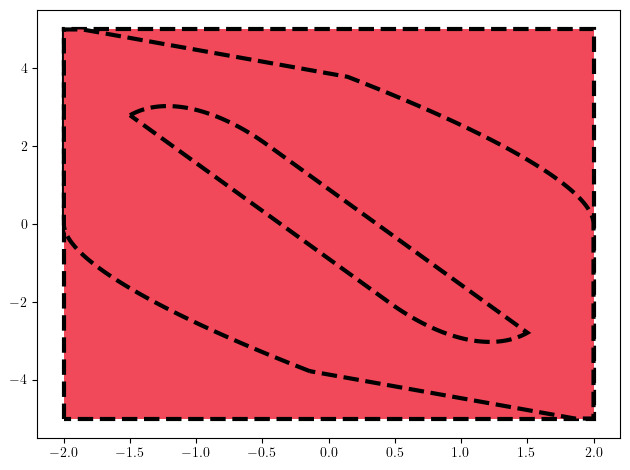

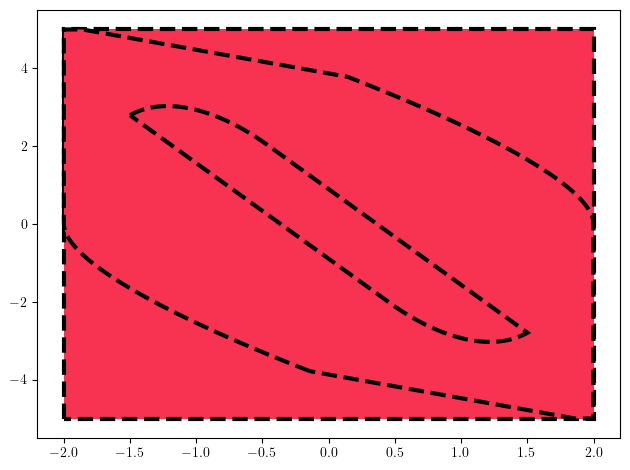

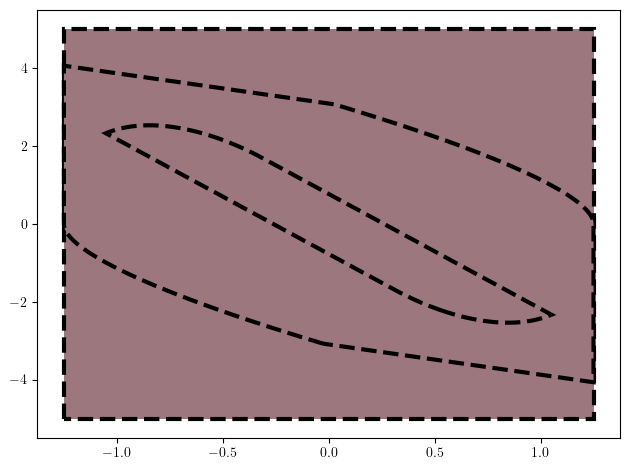

In [224]:
for model in models:
    model.plot_sets()

## Plots

### plot with reference and UAV position for spiral/ellipse and figure8 reference trajectory

In [225]:
def save_plot(path, noise = False, clean = True):
    if clean:
        tplt.clean_figure()
    tplt.save(path+'_thrust+par.tex')
    plt.legend(fontsize=plot_legend_font)
    plt.savefig(path+'_thrust+par.pdf',bbox_inches="tight")
    plt.show()
    # plt.savefig(path+'.tex',format="pgf")

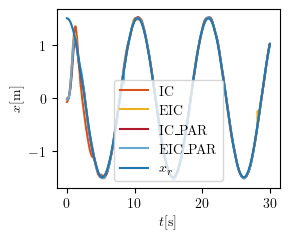

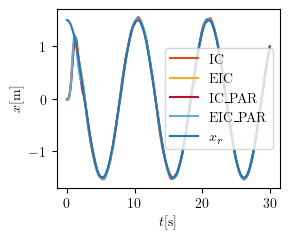

In [226]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][0][0, 0, :], label=controller.upper(), color = colors[i])
    plt.plot(time[trajectory][controllers[0]], data[trajectory][controllers[0]][1][0, :], label=r'$x_r$', color = ref_color)
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$x\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/x_'+trajectory)
    else:
        plt.legend()
        plt.show()

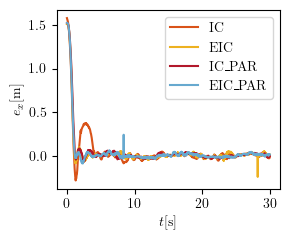

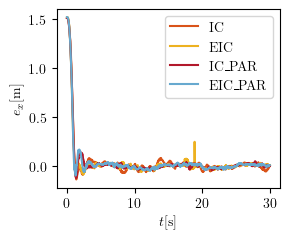

In [227]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][1][0, :]-data[trajectory][controller][0][0,0, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$e_x\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/e_x_'+trajectory)
    else:
        plt.legend()
        plt.show()

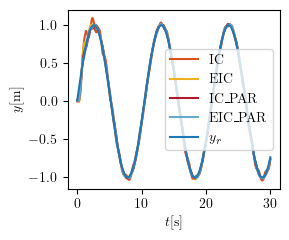

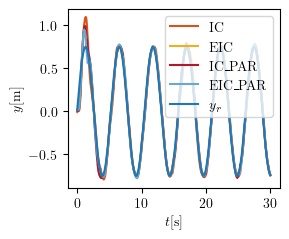

In [228]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][0][0,1, :], label=controller.upper(), color = colors[i])
    plt.plot(time[trajectory][controllers[0]], data[trajectory][controllers[0]][1][1, :], label=r'$y_r$', color = ref_color)
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$y\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/y_'+trajectory)
    else:
        plt.legend()
        plt.show()

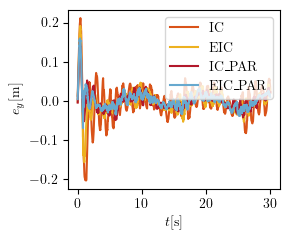

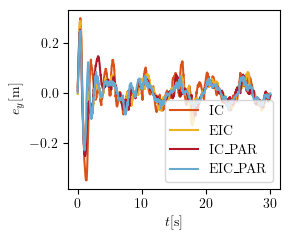

In [229]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][1][1, :]-data[trajectory][controller][0][0,1, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$e_y\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/e_y_'+trajectory)
    else:
        plt.legend()
        plt.show()

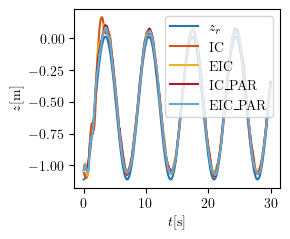

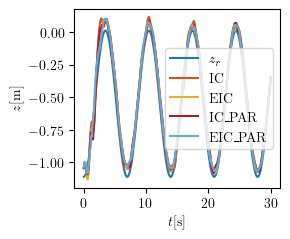

In [230]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.plot(time[trajectory][controllers[0]], data[trajectory][controllers[0]][1][2, :], label=r'$z_r$', color = ref_color)
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][0][0,2, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$z\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/z_'+trajectory)
    else:
        plt.legend()
        plt.show()

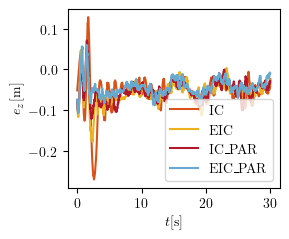

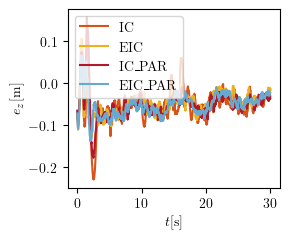

In [231]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][1][2, :]-data[trajectory][controller][0][0,2, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$e_z\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/e_z_'+trajectory)
    else:
        plt.legend()
        plt.show()

### plot with UAV velocity for spiral/ellipse and figure8 reference trajectory

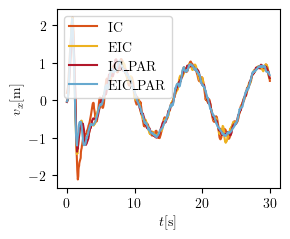

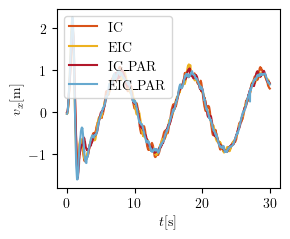

In [232]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][0][0,6, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$v_x\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/vx_'+trajectory)
    else:
        plt.legend()
        plt.show()

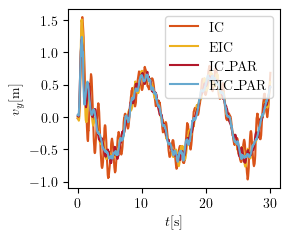

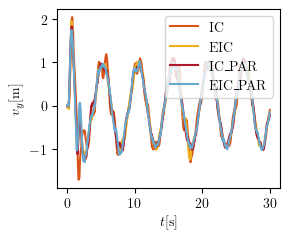

In [233]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][0][0,7, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$v_y\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/vy_'+trajectory)
    else:
        plt.legend()
        plt.show()

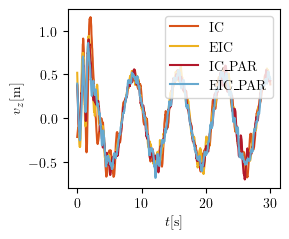

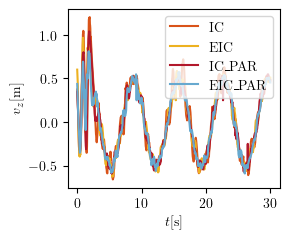

In [234]:
for trajectory in trajectories:
    fig = plt.figure(figsize=(3,2.5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][0][0,8, :], label=controller.upper(), color = colors[i])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$v_z\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/vz_'+trajectory)
    else:
        plt.legend()
        plt.show()

### path of UAV for spiral/ellipse and figure8 reference trajectory

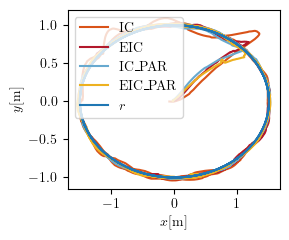

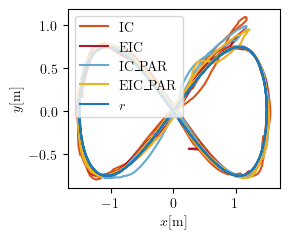

In [259]:
for trajectory in trajectories:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    for i, controller in enumerate(controllers):
        plt.plot(data[trajectory][controller][0][0, 0, :],
             data[trajectory][controller][0][0, 1, :], label=controller.upper(), color = colors[i])
    plt.plot(data[trajectory][controllers[0]][1][0, :],
             data[trajectory][controllers[0]][1][1, :], label='$r$', color = ref_color)
    plt.xlabel(r'$x\mathrm{[m]}$', fontsize=plot_label_font)
    plt.ylabel(r'$y\mathrm{[m]}$', fontsize=plot_label_font)
    if save_plots:
        tplt.clean_figure()
        tplt.save(folder_results+'plots/traj_xy_'+trajectory+'_thrust+par.pdf')
        plt.legend(loc='upper left', fontsize=plot_legend_font)
        plt.savefig(folder_results+'plots/traj_xy_'+trajectory+'_thrust+par.pdf',bbox_inches="tight")
        plt.show()
        # save_plot(folder_results+'plots/traj_xy_'+trajectory)
    else:
        plt.legend()
        plt.show()


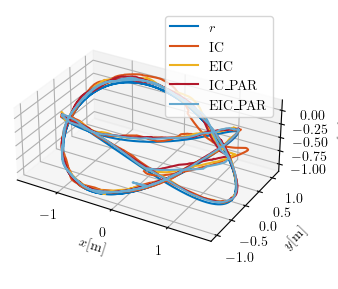

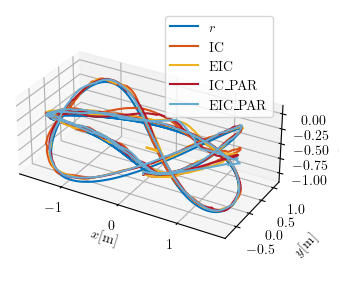

In [236]:
color_ref = (0.00000,0.44700,0.74100)
for trajectory in trajectories:
    colors_temp = [(0.85000,0.32500,0.09800),(0.92900,0.69400,0.12500),(0.69804,0.09412,0.16863),(0.40392,0.66275,0.81176)]
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.set_box_aspect((np.ptp(data[trajectory][controllers[0]][1][0, :]), np.ptp(data[trajectory][controllers[0]][1][1, :]), np.ptp(data[trajectory][controllers[0]][1][2, :])))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # plt.figure(figsize=(3,2.5))
    fig.set_figwidth(4.5)
    fig.set_figheight(3)
    ax.plot3D(data[trajectory][controllers[0]][1][0, :],
             data[trajectory][controllers[0]][1][1, :],data[trajectory][controllers[0]][1][2, :], label='$r$', color = color_ref)
    for controller, color in zip(controllers,colors_temp):
        ax.plot3D(data[trajectory][controller][0][0, 0, :],
             data[trajectory][controller][0][0, 1, :], data[trajectory][controller][0][0, 2, :],label=controller.upper(), color = color)
    ax.set_xlabel(r'$x\mathrm{[m]}$', fontsize=plot_label_font)
    ax.set_ylabel(r'$y\mathrm{[m]}$', fontsize=plot_label_font)
    ax.set_zlabel(r'$z\mathrm{[m]}$', fontsize=plot_label_font)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    ax.zaxis._axinfo['label']['space_factor'] = 2.8
    plt.rcParams["figure.autolayout"] = True
    # ax.set_box_aspect(aspect = None, zoom=0.7)
    plt.legend(fontsize=plot_legend_font)
    if save_plots:
        fig.savefig(folder_results+'plots/traj_xyz_'+trajectory+'_thrust+par.pdf')
        plt.show()
    else:
        plt.legend()
        plt.show()

### Ouput of controllers

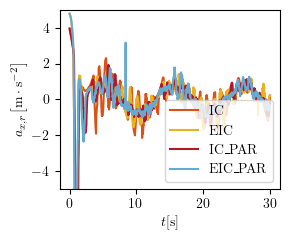

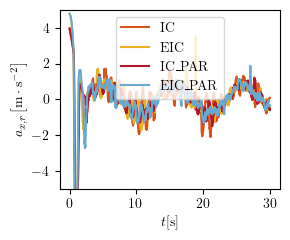

In [237]:
for trajectory in trajectories:
    # plot with control actions
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][2][0, :], label=controller.upper(), color = colors[i])
    axes = plt.gca()
    axes.set_ylim([-5,5])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$a_{x,r}\mathrm{\left[m\cdot s^{-2}\right]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/acc_x_'+trajectory, clean = False)
    else:
        plt.legend()
        plt.show()

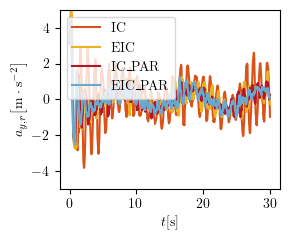

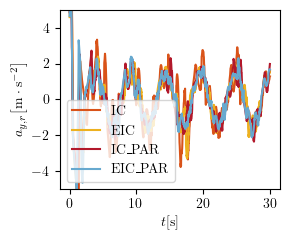

In [238]:
for trajectory in trajectories:
    # plot with control actions
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][2][1, :], label=controller.upper(), color = colors[i])
    axes = plt.gca()
    axes.set_ylim([-5,5])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$a_{y,r}\mathrm{\left[m\cdot s^{-2}\right]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/acc_y_'+trajectory)
    else:
        plt.legend()
        plt.show()

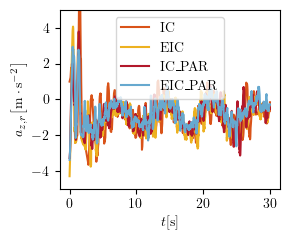

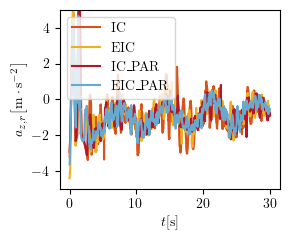

In [239]:
for trajectory in trajectories:
    # plot with control actions
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    for i, controller in enumerate(controllers):
        plt.plot(time[trajectory][controller], data[trajectory][controller][2][2, :], label=controller.upper(), color = colors[i])
    axes = plt.gca()
    axes.set_ylim([-5,5])
    plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
    plt.ylabel(r'$a_{z,r}\mathrm{\left[m\cdot s^{-2}\right]}$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/acc_z_'+trajectory)
    else:
        plt.legend()
        plt.show()

### Time needed to solve LP/QP

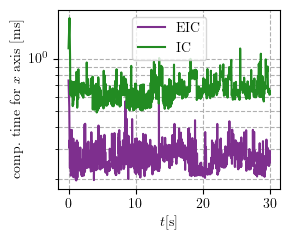

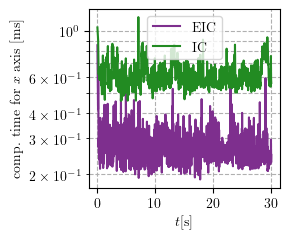

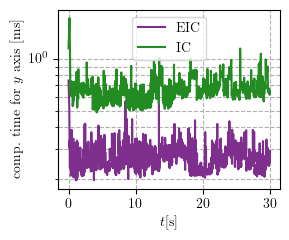

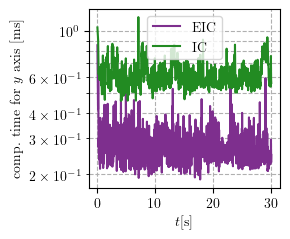

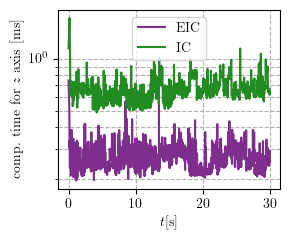

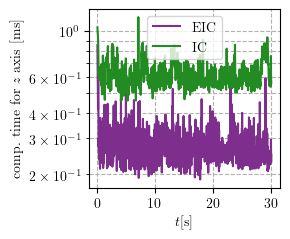

In [240]:
controllers_time = ['eic','ic'] # to draw in correct order because of overlapping
names = ['x','y','z']
for i, name in enumerate(names):
    for trajectory in trajectories:
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        plt.figure(figsize=(3,2.5))
        for controller, color in zip(controllers_time,colors_time):
            idx = np.where(data[trajectory][controller][4][0,:] != None)
            data_temp = data[trajectory][controller][4][0,:].copy()
            data_temp[idx] = data_temp[idx]*1e3
            plt.plot(time[trajectory][controller], data_temp, label=controller.upper(), color = color)
        plt.yscale('log')
        plt.grid(True, which="both", linestyle='--')
        plt.xlabel(r'$t\mathrm{[s]}$', fontsize=plot_label_font)
        plt.ylabel(r'comp. time for $'+name+'$ axis $\mathrm{[ms]}$', fontsize=plot_label_font)
        if save_plots:
            save_plot(folder_results+'plots/time_'+name+'_'+trajectory)
        else:
            plt.legend()
            plt.show()

#### Sum of both periods

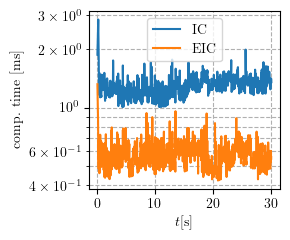

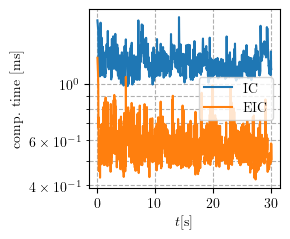

In [241]:
for trajectory in trajectories:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    for controller in reversed(controllers_time):
        idx = np.where(data[trajectory][controller][4][0,:] != None)
        data_temp = data[trajectory][controller][4][0,:].copy()
        data_temp2 = data[trajectory][controller][4][1,:].copy()
        data_temp2[idx] = data_temp2[idx]*1e3 + data_temp[idx]*1e3
        data_temp2 = np.where(data_temp2 < 1e-2, np.nan, data_temp2)
        plt.plot(time[trajectory][controller], data_temp2, label=controller.upper())
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--')
    plt.xlabel(r'$t$[s]', fontsize=plot_label_font)
    plt.ylabel(r'comp. time [ms]', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/time_sum_'+trajectory)
    else:
        plt.legend()
        plt.show()

### Time needed for control cascade to acquire control action

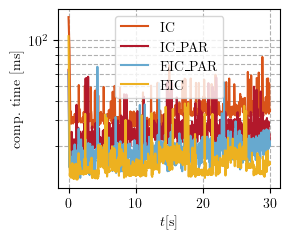

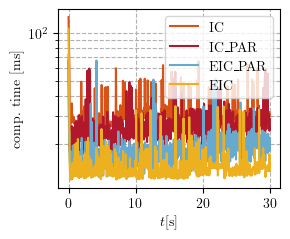

In [242]:
controllers_time = ['ic','ic_par','eic_par','eic'] # to draw in correct order because of overlapping

for trajectory in trajectories:
    colors = [(0.85000,0.32500,0.09800),(0.69804,0.09412,0.16863),(0.40392,0.66275,0.81176),(0.92900,0.69400,0.12500)]
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    for controller, color in zip(controllers_time,colors):
        plt.plot(time[trajectory][controller], dt_data[trajectory][controller]*1e3, label=controller.upper(), color = color)
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--')
    plt.xlabel(r'$t$[s]', fontsize=plot_label_font)
    plt.ylabel(r'comp. time [ms]', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/time_full_'+trajectory)
    else:
        plt.legend()
        plt.show()

### Interpolating coefficient

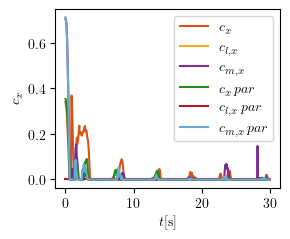

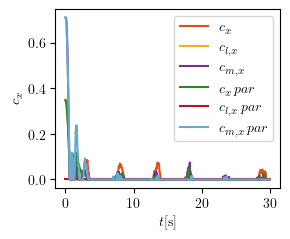

In [243]:
# plot with reference trajectory
for trajectory in trajectories:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    plt.plot(time[trajectory][controllers[0]], data[trajectory][controllers[0]][3][0, :], label=r'$c_x$', color = colors_full[0])
    plt.plot(time[trajectory][controllers[1]], data[trajectory][controllers[1]][3][0, 0, :], label=r'$c_{l,x}$', color = colors_full[1])
    plt.plot(time[trajectory][controllers[1]], data[trajectory][controllers[1]][3][1, 0, :], label=r'$c_{m,x}$', color = colors_full[2])
    plt.plot(time[trajectory][controllers[2]], data[trajectory][controllers[2]][3][0, :], label=r'$c_x\,par$', color = colors_full[3])
    plt.plot(time[trajectory][controllers[3]], data[trajectory][controllers[3]][3][0, 0, :], label=r'$c_{l,x}\,par$ ', color = colors_full[4])
    plt.plot(time[trajectory][controllers[3]], data[trajectory][controllers[3]][3][1, 0, :], label=r'$c_{m,x}\,par$', color = colors_full[5])
    plt.xlabel(r'$t$[s]', fontsize=plot_label_font)
    plt.ylabel(r'$c_x$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/c_x_'+trajectory)
    else:
        plt.legend()
        plt.show()

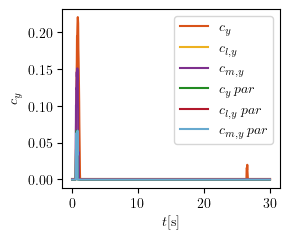

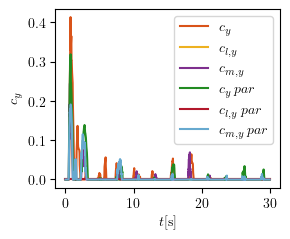

In [244]:
for trajectory in trajectories:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    plt.plot(time[trajectory][controllers[0]], data[trajectory][controllers[0]][3][1, :], label=r'$c_y$', color = colors_full[0])
    plt.plot(time[trajectory][controllers[1]], data[trajectory][controllers[1]][3][0, 1, :], label=r'$c_{l,y}$', color = colors_full[1])
    plt.plot(time[trajectory][controllers[1]], data[trajectory][controllers[1]][3][1, 1, :], label=r'$c_{m,y}$', color = colors_full[2])
    plt.plot(time[trajectory][controllers[2]], data[trajectory][controllers[2]][3][1, :], label=r'$c_y\,par$', color = colors_full[3])
    plt.plot(time[trajectory][controllers[3]], data[trajectory][controllers[3]][3][0, 1, :], label=r'$c_{l,y}\,par$ ', color = colors_full[4])
    plt.plot(time[trajectory][controllers[3]], data[trajectory][controllers[3]][3][1, 1, :], label=r'$c_{m,y}\,par$', color = colors_full[5])
    plt.xlabel(r'$t$[s]', fontsize=plot_label_font)
    plt.ylabel(r'$c_y$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/c_y_'+trajectory)
    else:
        plt.legend()
        plt.show()

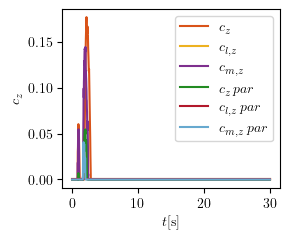

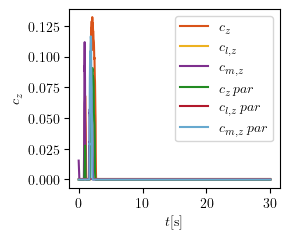

In [245]:
for trajectory in trajectories:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(3,2.5))
    plt.plot(time[trajectory][controllers[0]], data[trajectory][controllers[0]][3][2, :], label=r'$c_z$', color = colors_full[0])
    plt.plot(time[trajectory][controllers[1]], data[trajectory][controllers[1]][3][0, 2, :], label=r'$c_{l,z}$', color = colors_full[1])
    plt.plot(time[trajectory][controllers[1]], data[trajectory][controllers[1]][3][1, 2, :], label=r'$c_{m,z}$', color = colors_full[2])
    plt.plot(time[trajectory][controllers[2]], data[trajectory][controllers[2]][3][2, :], label=r'$c_z\,par$', color = colors_full[3])
    plt.plot(time[trajectory][controllers[3]], data[trajectory][controllers[3]][3][0, 2, :], label=r'$c_{l,z}\,par$ ', color = colors_full[4])
    plt.plot(time[trajectory][controllers[3]], data[trajectory][controllers[3]][3][1, 2, :], label=r'$c_{m,z}\,par$', color = colors_full[5])
    plt.xlabel(r'$t$[s]', fontsize=plot_label_font)
    plt.ylabel(r'$c_z$', fontsize=plot_label_font)
    if save_plots:
        save_plot(folder_results+'plots/c_z_'+trajectory)
    else:
        plt.legend()
        plt.show()

# Optimality, Integral Square Error, and Energy Consumption

In [246]:
nx = data[trajectory][controller][0].shape[1]
Q = np.zeros((nx,nx))
for i, model in enumerate(models):
    Q[i,i] = model.Q_h[0,0]
    Q[i+nx//2,i+nx//2] = model.Q_h[1,1]
    
nu = data[trajectory][controller][2].shape[0]
R = np.zeros((nu,nu))
for i, model in enumerate(models):
    R[i,i] = model.R_h

def eval_crit(state, control, Q, R):
    return state@Q@state.T + control@R@control.T

def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

def perc(x,l):
    return (x/l)*100-100

n = 3
nperc = 2
def eval_table(dict):
    df = pd.DataFrame.from_dict(dict)
    for trajectory in trajectories:
        df[trajectory] = df[trajectory].apply(lambda x: signif(x, n))
        df[trajectory + ' perc.'] = df[trajectory].apply(lambda x: perc(x,df.loc['eic_par'].at[trajectory]))
        df[trajectory + ' perc.'] = df[trajectory + ' perc.'].apply(lambda x: np.round(x, nperc))
    return df


def multipar_dict_to_df(nested_dict):
    reformed_dict = {}
    for outerKey, innerDict in nested_dict.items():
        for innerKey, values in innerDict.items():
            reformed_dict[(outerKey,
                        innerKey)] = values
        return pd.DataFrame(reformed_dict)

err = {}
ise = {}
total_ise = {}
total_energy = {}
energy_cons = {}
total_time = {}
max_time = {}
mean_time = {}
std_time = {}
crit = {}
for trajectory in trajectories:
    for controller in controllers:
        err_temp = []
        crit_temp = []
        for i, model in enumerate(models):
            err_temp.append(data[trajectory][controller][1][i,:] - data[trajectory][controller][0][0,i,:])
        err.setdefault(trajectory, {})[controller] = np.array(err_temp)
        ise_temp = np.sum(time_diff[trajectory][controller]*(err[trajectory][controller][:,:]**2), 1)
        ise.setdefault(trajectory, {})[controller] =  np.hstack((ise_temp, np.sum(ise_temp)))
        energy_temp = model.dt*np.sum(time_diff[trajectory][controller]*(data[trajectory][controller][2][:,:]**2), 1)
        energy_cons.setdefault(trajectory, {})[controller] = np.hstack((energy_temp, np.sum(energy_temp)))
        total_time_temp = np.sum(data[trajectory][controller][4],1)
        total_time.setdefault(trajectory, {})[controller] = np.hstack((total_time_temp, np.sum(total_time_temp)))
        mean_time_temp = np.mean(data[trajectory][controller][4]*1e3,1)
        mean_time.setdefault(trajectory, {})[controller] = np.hstack((mean_time_temp, np.mean(mean_time_temp)))
        std_time_temp = np.std(data[trajectory][controller][4]*1e3,1)
        std_time.setdefault(trajectory, {})[controller] = np.hstack((std_time_temp, np.std(std_time_temp)))
        max_time_temp = np.max(data[trajectory][controller][4]*1e3,1)
        max_time.setdefault(trajectory, {})[controller] = np.hstack((max_time_temp, np.max(max_time_temp)))
        total_ise.setdefault(trajectory, {})[controller] =  np.sum(ise_temp)
        total_energy.setdefault(trajectory, {})[controller] =  np.sum(energy_temp)
        crit.setdefault(trajectory, {})[controller] = np.sum(np.fromiter((time_diff[trajectory][controller][k]*eval_crit(data[trajectory][controller][1][:,k]-data[trajectory][controller][0][0,:,k], data[trajectory][controller][2][:,k], Q, R) for k in range(data[trajectory][controller][2].shape[1])), float))
    

### Criterion of optimality

Angle and angular rate in state vector are not reflected in criterion value as well as the torque, because they are manipulated by attitude controller.

In [247]:
df_crit = eval_table(crit)
df_crit[trajectories] = df_crit[trajectories]
df_crit

,spiral,figure8,spiral perc.,figure8 perc.
ic,22.7,24.7,65.69,22.28
eic,18.3,19.9,33.58,-1.49
ic_par,16.1,21.1,17.52,4.46
eic_par,13.7,20.2,0.00,0.00


### ISE

for each controller and sum

In [248]:
df_ise = eval_table(ise)
df_total_ise = eval_table(total_ise)
df_ise

,spiral,figure8,spiral perc.,figure8 perc.
ic,"[1.53, 0.0674, 0.15, 1.75]","[1.42, 0.162, 0.138, 1.73]","[11.68, 340.52, 108.33, 19.86]","[2.9, 117.16, 30.19, 10.9]"
eic,"[1.37, 0.0303, 0.12, 1.52]","[1.38, 0.0912, 0.0955, 1.57]","[0.0, 98.04, 66.67, 4.11]","[0.0, 22.25, -9.91, 0.64]"
ic_par,"[1.45, 0.0168, 0.105, 1.57]","[1.4, 0.0983, 0.117, 1.61]","[5.84, 9.8, 45.83, 7.53]","[1.45, 31.77, 10.38, 3.21]"
eic_par,"[1.37, 0.0153, 0.072, 1.46]","[1.38, 0.0746, 0.106, 1.56]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


### Energy consumption

for each controller and sum

In [249]:
df_energy = eval_table(energy_cons)
df_total_energy = eval_table(total_energy)
df_energy

,spiral,figure8,spiral perc.,figure8 perc.
ic,"[0.559, 0.536, 0.641, 1.74]","[0.497, 0.873, 0.717, 2.09]","[28.21, 280.14, 80.56, 86.7]","[0.81, 34.51, 49.38, 29.01]"
eic,"[0.494, 0.219, 0.589, 1.3]","[0.479, 0.669, 0.534, 1.68]","[13.3, 55.32, 65.92, 39.48]","[-2.84, 3.08, 11.25, 3.7]"
ic_par,"[0.389, 0.152, 0.454, 0.995]","[0.435, 0.617, 0.598, 1.65]","[-10.78, 7.8, 27.89, 6.76]","[-11.76, -4.93, 24.58, 1.85]"
eic_par,"[0.436, 0.141, 0.355, 0.932]","[0.493, 0.649, 0.48, 1.62]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


### Merged table

In [250]:
def get_crit_table(df, original_names, new_name):
    df_merged = []
    for i, original_name in enumerate(original_names):
        df_merged.append(df.filter(regex=original_name, axis=1).copy())
        df_merged[-1].rename(columns = {original_name: new_name, original_name + ' perc.': new_name+' %'}, inplace = True)
        
    return df_merged
df_merged_crit = get_crit_table(df_crit, trajectories, 'J')
df_merged_ise = get_crit_table(df_total_ise, trajectories, 'ISE')
df_merged_energy = get_crit_table(df_total_energy, trajectories, 'E')

df_merged_crit, df_merged_ise, df_merged_energy

([            J    J %
  ic       22.7  65.69
  eic      18.3  33.58
  ic_par   16.1  17.52
  eic_par  13.7   0.00,
              J    J %
  ic       24.7  22.28
  eic      19.9  -1.49
  ic_par   21.1   4.46
  eic_par  20.2   0.00],
 [          ISE  ISE %
  ic       1.75  19.86
  eic      1.52   4.11
  ic_par   1.57   7.53
  eic_par  1.46   0.00,
            ISE  ISE %
  ic       1.73  10.90
  eic      1.57   0.64
  ic_par   1.61   3.21
  eic_par  1.56   0.00],
 [             E    E %
  ic       1.740  86.70
  eic      1.300  39.48
  ic_par   0.995   6.76
  eic_par  0.932   0.00,
              E    E %
  ic       2.09  29.01
  eic      1.68   3.70
  ic_par   1.65   1.85
  eic_par  1.62   0.00])

In [251]:
def merge_tables(list_of_tables):
    dfs_merged = []
    for i, trajectory in enumerate(trajectories):
        merge = list_of_tables[0][i].copy()
        for j in range(1,len(list_of_tables)):
            merge = pd.merge(merge, list_of_tables[j][i], left_index=True, right_index=True,how='outer')
        dfs_merged.append(merge)
    return dfs_merged

dfs_merged = merge_tables([df_merged_crit, df_merged_ise, df_merged_energy])
dfs_merged

[            J    J %   ISE  ISE %      E    E %
 ic       22.7  65.69  1.75  19.86  1.740  86.70
 eic      18.3  33.58  1.52   4.11  1.300  39.48
 ic_par   16.1  17.52  1.57   7.53  0.995   6.76
 eic_par  13.7   0.00  1.46   0.00  0.932   0.00,
             J    J %   ISE  ISE %     E    E %
 ic       24.7  22.28  1.73  10.90  2.09  29.01
 eic      19.9  -1.49  1.57   0.64  1.68   3.70
 ic_par   21.1   4.46  1.61   3.21  1.65   1.85
 eic_par  20.2   0.00  1.56   0.00  1.62   0.00]

In [252]:
for df, trajectory in zip(dfs_merged, trajectories):
    buf = folder_results+"table_crit_lab_"+trajectory+"_thrust+par.tex"
    caption = "Evaluation of the criterion, ISE, and energy consumption for the IC, eIC, and parallelized IC and eIC for the tracking of "+trajectory+" reference trajectory  in the laboratory experiment"
    label = "tab:comparison-crit-lab-thrust+par-"+trajectory+""
    column_format = "lcccccc"
    s = df.style
    s.format({
        ("J %"): '{:,.2f}',
        ("ISE %"): '{:,.2f}',
        ("ISE"): '{:,.2f}',
        ("E %"): '{:,.2f}',
        ("E"): '{:,.2f}',
        }, precision=4)
    # form = [None, '${:,.2f}'.format, None, '${:,.2f}'.format]
    s.to_latex(buf = buf, caption = caption, label = label, column_format = column_format, hrules=True)

### Total time for solving the LPs/QPs

for each controller and sum

In [253]:
df_time_total = eval_table(total_time)
df_time_total

,spiral,figure8,spiral perc.,figure8 perc.
ic,"[0.594, 0.56, 0.477, 1.63]","[0.601, 0.597, 0.495, 1.69]","[2.95, 2.38, -7.56, -0.61]","[2.39, 6.8, -6.25, 1.2]"
eic,"[0.52, 0.582, 0.48, 1.58]","[0.572, 0.635, 0.529, 1.74]","[-9.88, 6.4, -6.98, -3.66]","[-2.56, 13.6, 0.19, 4.19]"
ic_par,"[0.836, 0.794, 0.694, 2.32]","[0.831, 0.818, 0.692, 2.34]","[44.89, 45.16, 34.5, 41.46]","[41.57, 46.33, 31.06, 40.12]"
eic_par,"[0.577, 0.547, 0.516, 1.64]","[0.587, 0.559, 0.528, 1.67]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


### MAX Period for solving the LPs/QPs

for each controller and global max in [ms]

In [254]:
df_time_max = eval_table(max_time)
df_time_max

,spiral,figure8,spiral perc.,figure8 perc.
ic,"[1.72, 1.12, 1.05, 1.72]","[1.18, 1.15, 0.821, 1.18]","[70.3, 45.27, 64.58, 70.3]","[21.65, 27.07, -48.36, -25.79]"
eic,"[0.747, 0.617, 0.553, 0.747]","[0.857, 0.675, 0.657, 0.857]","[-26.04, -19.97, -13.32, -26.04]","[-11.65, -25.41, -58.68, -46.1]"
ic_par,"[1.35, 1.24, 1.09, 1.35]","[1.69, 1.53, 1.02, 1.69]","[33.66, 60.83, 70.85, 33.66]","[74.23, 69.06, -35.85, 6.29]"
eic_par,"[1.01, 0.771, 0.638, 1.01]","[0.97, 0.905, 1.59, 1.59]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


### Mean Period for solving the LPs/QPs

for each controller and global mean in [ms]

In [255]:
df_time_mean = eval_table(mean_time)
df_time_mean

,spiral,figure8,spiral perc.,figure8 perc.
ic,"[0.656, 0.618, 0.527, 0.6]","[0.605, 0.602, 0.499, 0.569]","[80.22, 79.13, 62.15, 73.91]","[69.94, 77.58, 55.45, 67.85]"
eic,"[0.264, 0.296, 0.244, 0.268]","[0.272, 0.301, 0.251, 0.275]","[-27.47, -14.2, -24.92, -22.32]","[-23.6, -11.21, -21.81, -18.88]"
ic_par,"[0.69, 0.656, 0.573, 0.64]","[0.721, 0.709, 0.6, 0.677]","[89.56, 90.14, 76.31, 85.51]","[102.53, 109.14, 86.92, 99.71]"
eic_par,"[0.364, 0.345, 0.325, 0.345]","[0.356, 0.339, 0.321, 0.339]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


### STD Period for solving the LPs/QPs

for each controller and global STD in [ms]

In [256]:
df_time_std = eval_table(std_time)
df_time_std

,spiral,figure8,spiral perc.,figure8 perc.
ic,"[0.102, 0.0806, 0.0729, 0.0124]","[0.082, 0.0799, 0.0562, 0.0117]","[122.71, 68.97, 56.44, 1461.71]","[86.36, 52.19, -6.02, 80.83]"
eic,"[0.0399, 0.0403, 0.0366, 0.00164]","[0.045, 0.045, 0.0424, 0.00122]","[-12.88, -15.51, -21.46, 106.55]","[2.27, -14.29, -29.1, -81.14]"
ic_par,"[0.105, 0.0878, 0.0837, 0.00902]","[0.119, 0.111, 0.0837, 0.015]","[129.26, 84.07, 79.61, 1036.02]","[170.45, 111.43, 39.97, 131.84]"
eic_par,"[0.0458, 0.0477, 0.0466, 0.000794]","[0.044, 0.0525, 0.0598, 0.00647]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


### Period evaluation for whole cascade

In [257]:
def print_statictics(df):
    print("max dt [ms]:")
    print(df.max()*1e3)
    print("mean dt [ms]:")
    print(df.mean()*1e3)
    print("std dt [ms]:")
    print(df.std()*1e3)
    print("sum dt [s]:")
    print(df.sum())
    
def df_dt2stat(nested_dict):
    dfs = []
    for outerKey, innerDict in nested_dict.items():
        time_sum = []
        time_max = []
        time_N = []
        time_mean = []
        index = []
        for innerKey, values in innerDict.items():
            # reformed_dict[(outerKey,
            #             innerKey)] = values
            # data = {innerKey:['Tom', 'nick', 'krish', 'jack'], 'Age':[20, 21, 19, 18]}
            time_sum.append(values.sum().round().astype(int))
            time_N.append(values.shape[0])
            time_mean.append(values.mean()*1e3)
            time_mean[-1] = time_mean[-1].round().astype(int)
            time_max.append(values.max()*1e3)
            time_max[-1] = time_max[-1].round().astype(int)
            index.append(innerKey)
            
        dfs.append(pd.DataFrame())
        dfs[-1]['t [s]'] = time_sum
        dfs[-1].index = index
        dfs[-1]['t %'] = dfs[-1]['t [s]'].apply(lambda x: perc(x,dfs[-1].loc['eic_par'].at['t [s]'])).round(nperc)
        dfs[-1]['N'] = time_N
        dfs[-1]['N %'] = dfs[-1]['N'].apply(lambda x: perc(x,dfs[-1].loc['eic_par'].at['N'])).round(nperc)
        dfs[-1]['t_mean [ms]'] = time_mean
        dfs[-1]['t_mean %'] = dfs[-1]['t_mean [ms]'].apply(lambda x: perc(x,dfs[-1].loc['eic_par'].at['t_mean [ms]'])).round(nperc)
        dfs[-1]['t_max [ms]'] = time_max
        dfs[-1]['t_max %'] = dfs[-1]['t_max [ms]'].apply(lambda x: perc(x,dfs[-1].loc['eic_par'].at['t_max [ms]'])).round(nperc)
            
        
    return dfs
    

df_dt_stat = df_dt2stat(dt_data)
for df in df_dt_stat:
    print(df)

         t [s]   t %     N    N %  t_mean [ms]  t_mean %  t_max [ms]  t_max %
ic          30  3.45   906 -42.91           33     73.68         142   111.94
eic         30  3.45  1968  24.01           15    -21.05         106    58.21
ic_par      30  3.45  1211 -23.69           24     26.32          64    -4.48
eic_par     29  0.00  1587   0.00           19      0.00          67     0.00
         t [s]   t %     N    N %  t_mean [ms]  t_mean %  t_max [ms]  t_max %
ic          30  3.45   993 -39.75           30     66.67         125    71.23
eic         30  3.45  2106  27.79           14    -22.22         106    45.21
ic_par      30  3.45  1153 -30.04           26     44.44          67    -8.22
eic_par     29  0.00  1648   0.00           18      0.00          73     0.00


In [258]:
for df, trajectory in zip(df_dt_stat, trajectories):
    buf = folder_results+"table_time_lab_"+trajectory+"_thrust+par.tex"
    caption = "The time demands for the IC, eIC, and parallelized IC and eIC for the tracking of "+trajectory+" reference trajectory in the laboratory experiment"
    label = "tab:comparison-time-lab-thrust-par-"+trajectory
    column_format = "lcccc"
    s = df.style
    s.format({
        ("t %"): '{:,.2f}',
        ("N %"): '{:,.2f}',
        ("t_mean %"): '{:,.2f}',
        ("t_max %"): '{:,.2f}'
        })
    # form = [None, '${:,.2f}'.format, None, '${:,.2f}'.format]
    s.to_latex(buf = buf, caption = caption, label = label, column_format = column_format, hrules=True)